In [1]:
import os, re, multiprocessing
import pandas as pd

import requests
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from string import ascii_letters

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

from nltk.stem import PorterStemmer
ps = PorterStemmer()

from nltk.corpus import stopwords
stopwords_id = pd.read_csv('stopwords-id.txt', delimiter='\n')
stop_words_en = set(stopwords.words('english'))

from elang.plot.utils import plot2d
from elang.plot.utils import plotNeighbours

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

words_not_in_wiki = []

In [2]:
model = Word2Vec.load('updated_model.model')

In [3]:
# model lama
#model.most_similar("inflasi")

In [4]:
def _get_wikipedia_article(slug, url_base):
    url_query = url_base + str(slug) # https://id.wikipedia.org/wiki/[slug]
    req = requests.get(url_query)
    soup = BeautifulSoup(req.content, "html.parser") # returns the html source code of the page

    article = {}
    article["title"] = soup.find("h1", attrs={"class": "firstHeading"}).text
    article["url"] = url_query

    find_div = soup.find("div", attrs={"class": "mw-parser-output"})
    if find_div is None:
        return
    for s in find_div(["script", "style", "table", "div"]):
        s.decompose()

    find_content = find_div.findAll(
        ["p", "li", "h2.span.mw-headline", "h3.span.mw-headline"]
    ) # determines the content section

    article["content"] = " ".join(
        [re.sub(r"\s+", " ", row.text) for row in find_content]
    ) # cleans the content

    find_redirect_link = find_div.findAll("a", attrs={"class": "mw-redirect"})
    article["related_queries"] = [link["href"][6:] for link in find_redirect_link]
    return article

In [5]:
def stem(word):
    result = stemmer_id.stem(word)
    
    if result == word:
        result = ps.stem(word)
    
    return result

In [6]:
def build_from_wikipedia_branch(slug, levels, lang="id"):

    articles = []
    url_base = f"https://{lang}.wikipedia.org/wiki/"
    
    try:
        article = _get_wikipedia_article(slug, url_base) # returns the title, url, content, and related queries
        related_queries = set(article["related_queries"]) # gets all related queries
    except:
        print("Couldn't find Wikipedia article with the supplied title.")
        return

    all_queries = list(related_queries) + [slug]
    queried = []

    for i in range(int(levels)): # getting the content from related queries
        new_queries = []
        for que in set(all_queries):
            if que not in queried and que != "":
                article = _get_wikipedia_article(que, url_base)
                articles.append(article)
                queried.append(que)
                new_queries.extend(article["related_queries"])
        all_queries = list(set(new_queries))
        #print(f"Level {i+1} Queried so far: {queried} \n")
        
    content_list = [d["content"] for d in articles if "content" in d.keys()]
    corpus = list(map(simple_preprocess, content_list)) # cleaning the text (preprocessing)
    
    final_corpus = []
    
    #print("Words that have unique symbols:")
    count_no = 1
    
    for i in corpus:
        temp_corpus = []
        
        for j in i:
            if set(j).difference(ascii_letters):
                # print(str(count_no) + ". " + str(j))
                count_no += 1
            else:
                word = stem(j)
                
                if word in stopwords_id['Stopwords'].values:
                    continue
                elif word in stop_words_en:
                    continue
                else:
                    temp_corpus.append(word)
            
        final_corpus.append(temp_corpus)
        
    return final_corpus

In [7]:
def update_model(corpus):
    print("Before: " + str(len(model.wv.vocab)))
    
    model.build_vocab(corpus, update=True)
    model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)
    
    print("After: " + str(len(model.wv.vocab)))

In [8]:
def gather_data_from_wiki(title, branch=1):
    
    try:
        val = int(title)
        print("Title must be a string!")  
    except ValueError:
        try:
            val = int(branch)
        
            corpus = build_from_wikipedia_branch(slug=title, levels=branch)
            if(corpus is None):
                title2 = title.upper()
                corpus2 = build_from_wikipedia_branch(slug=title2, levels=branch)
                
                if(corpus2 is None):
                    words_not_in_wiki.append(title2)
                    return
                else:
                    update_model(corpus2)
            else:
                update_model(corpus)
        except ValueError:
            print("Branch must be an int!")

In [9]:
def textfile_clean(textfile):
    with open(textfile, 'r') as file:
        data = file.read()
    
    split = data.split("\n")
    
    keywords = []

    for i in split:
        if(i != ""):
            i = i.rstrip()
            print(i)
            gather_data_from_wiki(i, 2)

In [10]:
textfile_clean("keywords.txt")

Pertumbuhan ekonomi
Before: 32015
After: 32614
pertumbuhan pdb
Couldn't find Wikipedia article with the supplied title.
Couldn't find Wikipedia article with the supplied title.
pertumbuhan produktivitas
Couldn't find Wikipedia article with the supplied title.
Couldn't find Wikipedia article with the supplied title.
pdb
Couldn't find Wikipedia article with the supplied title.
Before: 32614
After: 32956
produk domestik bruto
Before: 32956
After: 32956
Produk domestik
Couldn't find Wikipedia article with the supplied title.
Couldn't find Wikipedia article with the supplied title.
Domestik bruto
Couldn't find Wikipedia article with the supplied title.
Couldn't find Wikipedia article with the supplied title.
Ekonomi tumbuh
Couldn't find Wikipedia article with the supplied title.
Couldn't find Wikipedia article with the supplied title.
Ekonomi indonesia tumbuh
Couldn't find Wikipedia article with the supplied title.
Couldn't find Wikipedia article with the supplied title.
Produk nasional
Cou

In [7]:
# model baru

model.most_similar("ekonomi")

[('stati', 0.6634241342544556),
 ('vsnkh', 0.655521035194397),
 ('negara', 0.6549239158630371),
 ('industri', 0.636488139629364),
 ('sovknarkom', 0.6340448260307312),
 ('sosial', 0.6320282816886902),
 ('mutuali', 0.6315522193908691),
 ('keb', 0.6302899718284607),
 ('soltou', 0.628473162651062),
 ('partisipatori', 0.6283261179924011)]

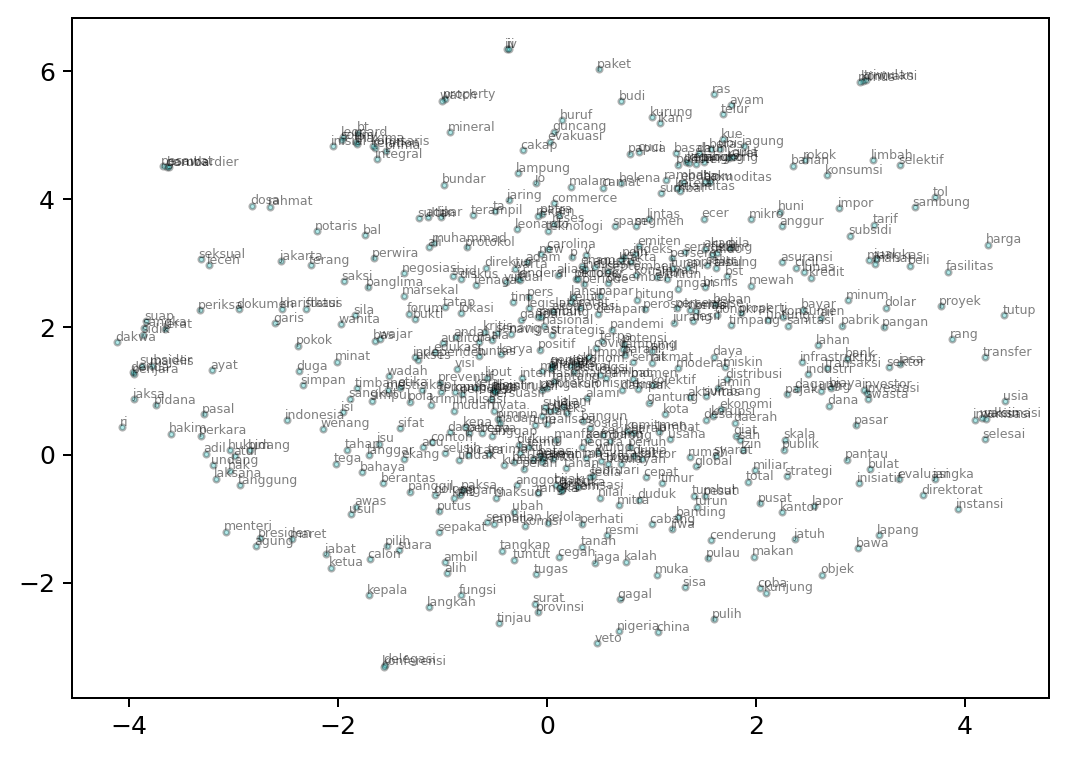

In [12]:
plot2d(model)

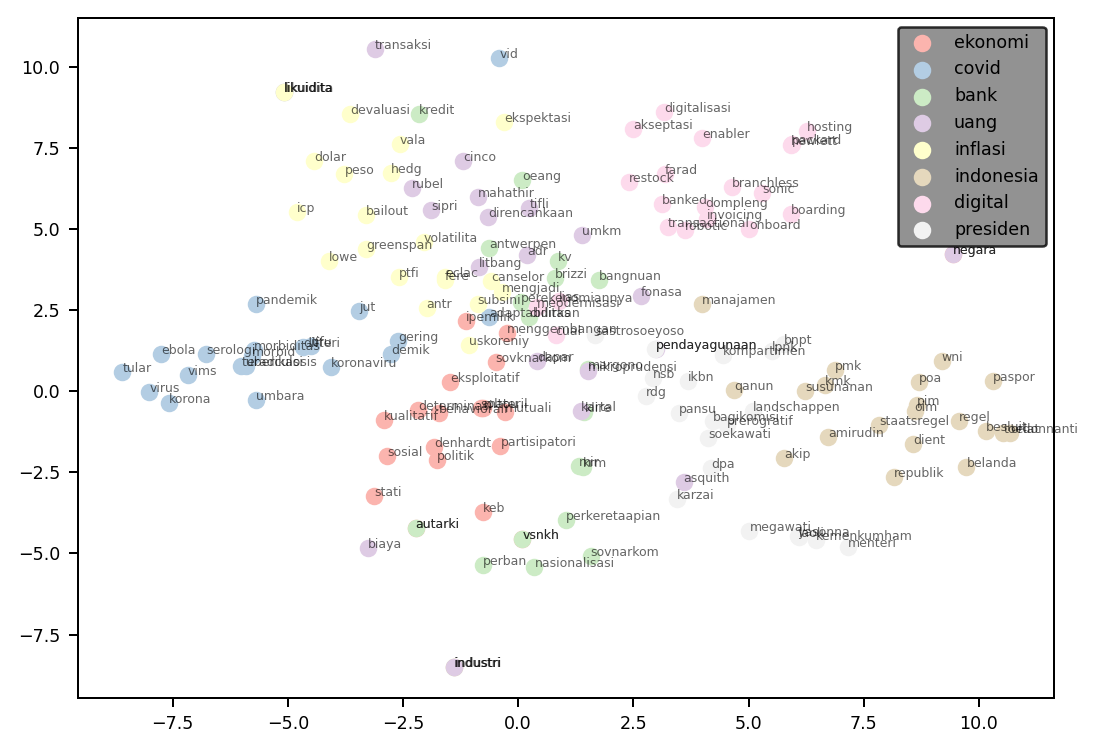

In [3]:
words = ['ekonomi', 'covid', 'bank', 'uang', 'inflasi', 'indonesia', 'digital', 'presiden']

plotNeighbours(model, 
    words, 
    method="TSNE", 
    k=20,
    draggable=True)

In [14]:
model.save("updated_model.model")

In [15]:
words_not_in_wiki

['PERTUMBUHAN PDB',
 'PERTUMBUHAN PRODUKTIVITAS',
 'PRODUK DOMESTIK',
 'DOMESTIK BRUTO',
 'EKONOMI TUMBUH',
 'EKONOMI INDONESIA TUMBUH',
 'PRODUK NASIONAL',
 'EKSPANSI EKONOMI',
 'NASIONAL BRUTO',
 'PROYEKSI PERTUMBUHAN',
 'OUTPUT EKONOMI',
 'PNB',
 'TINGKAT PERTUMBUHAN',
 'PERTUMBUHAN TAHUNAN',
 'PERLAMBATAN EKONOMI',
 'EKONOMI AKAN TUMBUH',
 'PENGEMBANGAN EKONOMI',
 'PERKEMBANGAN EKONOMI',
 'DATA MAKROEKONOMI',
 'VARIASI MUSIMAN',
 'BARANG TAHAN LAMA',
 'BELANJA KONSTRUKSI',
 'PENYESUAIAN MUSIMAN',
 'BUKAN PENDUDUK',
 'PERSEDIAAN BISNIS',
 'BARANG TIDAK TAHAN LAMA',
 'TAHAN LAMA',
 'INDEKS MANAJER',
 'PESANAN PABRIK',
 'INDEKS MANAJER PEMBELIAN',
 'INDEKS MANUFAKTUR',
 'MANAJEMEN PERSEDIAAN',
 'AKTIVITAS MANUFAKTUR',
 'KLAIM AWAL MUSIMAN',
 'INDIKATOR PEMANDU',
 'KETIDAKPASTIAN EKONOMI',
 'PENURUNAN TAJAM',
 'KEMUNDURAN TAJAM',
 'KECENDERUNGAN MENURUN',
 'TITIK TERANG',
 'EKONOMI LEMAH',
 'PELEMAHAN EKONOMI',
 'PEMULIHAN EKONOMI',
 'TITIK TERENDAH',
 'PERLAMBATAN EKONOMI',
 'PELEMAHA